In [1]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_debug_nans", True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as jnp
import jax.random as jrng
import jax.scipy as jsp
import jax.nn as jnn
import numpy as np
import ultraplot as uplt

In [ ]:

MIN = 0
MAX = 1
MU = 0
N_DIMS = 2
EGGBOX_MAX_ARG = 5.0 * jnp.pi

TRUE_LOG_Z = N_DIMS * np.log((sp.stats.norm.cdf(MAX-MU) - sp.stats.norm.cdf(MIN-MU))/(MAX-MIN))


def _neg_log_like_gauss1d(x, sigma, mu=0.0):
    return jnp.sum(0.5 * (x-mu)**2 / sigma**2 + jnp.log(sigma) + 0.5 * jnp.log(2.0 * jnp.pi))

def _neg_log_like(x):
    # y = x[0]
    # x = x[1:]
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, jnp.exp(y / 2))
    # return _neg_log_like_gauss1d(y, 3) + _neg_log_like_gauss1d(x, 200)

    # return jnp.sum(((1 - y)**2 + 100.0 * (x - y**2)**2) / 20)

    # return (jnp.sum(x**2) - 1)**2 / 0.25**2

    # return _neg_log_like_gauss1d(x, 1, mu=MU)
    x = 2.0 * EGGBOX_MAX_ARG * x - EGGBOX_MAX_ARG
    return -1.0 * jnp.power(2. + jnp.prod(jnp.cos(0.5 * x)), 3)
    # return -1.0 * jsp.special.logsumexp(
    #     jnp.array([
    #         jnp.log(0.25) - _neg_log_like_gauss1d(x, 0.25),
    #         jnp.log(0.75) - _neg_log_like_gauss1d(x, 1, mu=MU),
    #     ])
    # )


def _transform(x):
    return (MAX - MIN) * jnn.sigmoid(x) + MIN

def _inv_transform(y):
    x = (y - MIN) / (MAX - MIN)
    return jsp.special.logit(x)

def _log_like(x):
    y = _transform(x)
    return -1.0 * _neg_log_like(y)

def _log_prior(x):
    sx = jnn.log_sigmoid(x)
    return jnp.sum(2 * sx - x)

def _prior_draw(rng_key):
    y = jrng.uniform(rng_key, shape=(N_DIMS,), minval=MIN, maxval=MAX)
    return _inv_transform(y)


In [ ]:
from nested_sampling_hmc import nested_sampler_hmc

rng_key = jrng.PRNGKey(seed=21)
n_dims = N_DIMS
n_live = 10000
n_iter_max = 100000
n_iter_conv_fac = 2
n_walkers_hmc = 10
n_samples_hmc = 10
leapfrog_step_size_hmc = 0.1
n_leapfrog_steps_hmc = 10

(logZ, delta_logZ, samps, logw, loglike, ns_data) = nested_sampler_hmc(
    rng_key,
    _log_like,
    _log_prior,
    _prior_draw,
    n_dims,
    n_live,
    n_iter_max,
    n_iter_conv_fac,
    n_walkers_hmc,
    n_samples_hmc,
    leapfrog_step_size_hmc,
    n_leapfrog_steps_hmc,
)

print("logZ|err:", logZ, delta_logZ)
print("true logZ:", TRUE_LOG_Z)
print("H:", ns_data.H)

sampling (logZ: 2.25171e+01): 100%|██████| 66560/66560 [03:43<00:00, 297.89it/s]


logZ|err: 22.61959218989036 0.01825575555557417
true logZ: -2.149724653724143
H: 3.332726109048771


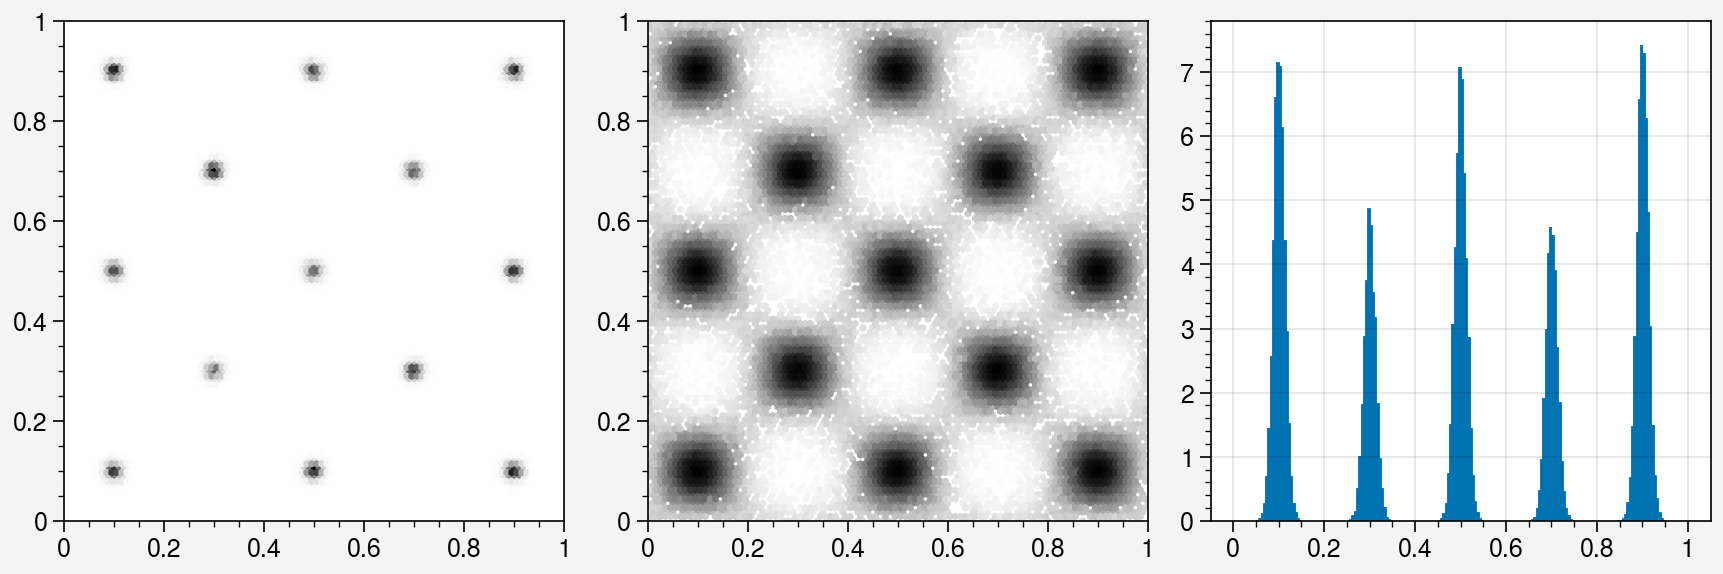

In [87]:
wgts = jnp.exp(logw)
msk = np.abs(_transform(samps[:, 1]) - 2) < 0.2

ng = 100
cmap = "grays"

fig, axs = uplt.subplots(ncols=3, nrows=1, share=0)

axs[0, 0].hexbin(
    _transform(samps[:, 0]),
    _transform(samps[:, 1]),
    weights=wgts,
    reduce_C_function=np.sum,
    gridsize=ng,
    cmap=cmap,
    discrete=False,
    norm="linear",
    extent=(0, 1, 0, 1)
);
axs[0, 0].format(grid=False, xlim=(0, 1), ylim=(0, 1))

axs[0, 1].hexbin(
    _transform(samps[:, 0]),
    _transform(samps[:, 1]),
    weights=wgts,
    reduce_C_function=np.sum,
    gridsize=ng,
    cmap=cmap,
    discrete=False,
    norm="log",
    extent=(0, 1, 0, 1)
)
axs[0, 1].format(grid=False, xlim=(0, 1), ylim=(0, 1))

axs[0, 2].hist(
    _transform(samps[:, 0]),
    weights=wgts,
    density=True,
    bins=ng * 2,
);

In [27]:
from affine_invar_hmc import ensemble_hmc

n_dims = N_DIMS
n_walkers = max(2 * n_dims, 20) # max(2 * n_dims, 200)
n_samples = 100000

rng_key = jrng.PRNGKey(seed=10)
rng_key, init_key = jrng.split(rng_key)
x_init_af = jrng.normal(init_key, shape=(n_walkers, n_dims)) * 0.01

n_steps = 2
h = 1 / n_steps
chain, acc, nloglike = ensemble_hmc(
    _neg_log_like,
    x_init_af,
    n_samples,
    n_dims,
    n_walkers,
    h,
    n_steps,
    rng_key
)


sampling: 100%|██████████████████████| 100000/100000 [00:03<00:00, 31325.20it/s]

acceptance rate: 0.00%


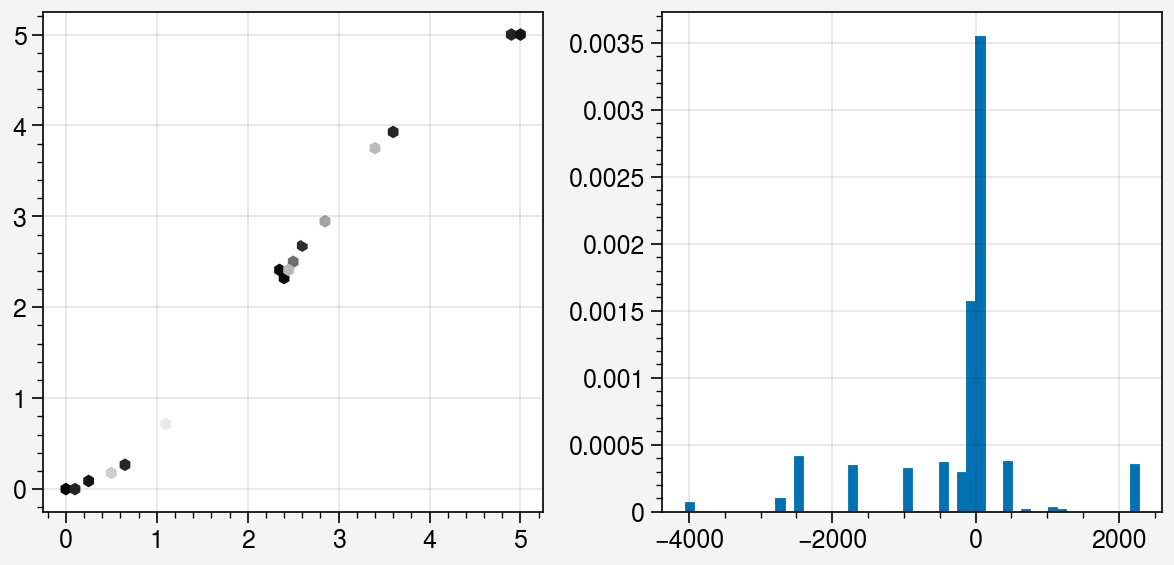

In [ ]:
fig, axs = uplt.subplots(ncols=2, nrows=1, share=0)

axs[0, 0].hexbin(
    chain[:, :, 0].ravel(),
    chain[:, :, 1].ravel(),
    gridsize=50,
    cmap="greys",
    discrete=False,
    norm="log"
)

axs[0, 1].hist(
    chain[:, :, 0].ravel(),
    density=True,
    bins=50,
    # log=True,
);

In [33]:
import tensorflow_probability.substrates.jax as tfp
from jax import random
from jaxns import Prior, Model
from jaxns import NestedSampler

tfpd = tfp.distributions

def prior_model():
    x = yield Prior(tfpd.Uniform(MIN, MAX), name='x')
    return x


model = Model(
    prior_model=prior_model,
    log_likelihood=_log_like
)

exact_ns = NestedSampler(model=model, max_samples=1e4, c=100)

termination_reason, state = exact_ns(random.PRNGKey(42))
results = exact_ns.to_results(termination_reason=termination_reason, state=state)

exact_ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 32386
samples: 850
phantom samples: 0
likelihood evals / sample: 38.1
phantom fraction (%): 0.0%
--------
logZ=-1.315 +- 0.034
max(logL)=-0.919
H=-0.07
ESS=101
--------
x: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x: 0.21 +- 0.9 | -1.03 / 0.16 / 1.49 | -0.0 | -0.0
--------
